<a href="https://colab.research.google.com/github/amankiitg/GenAI/blob/main/Live_LLMScratch_Final_Experiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BUILD A LARGE LANGUAGE MODEL FROM SCRATCH

### STEP 1: LOADING THE DATASET


In [6]:
# !pip install datasets

In [7]:
import os
# from datasets import load_dataset

file_path = "pg76057.txt"

# Check if the file exists in the current directory (i.e., Colab session)
if os.path.exists(file_path):
    with open(file_path, "r", encoding="utf-8") as file:
        text_data = file.read()
    print(f"File '{file_path}' loaded with {len(text_data)} characters.")
else:
    # Load a subset of The Pile (e.g., StackExchange, Books3, etc.)
    # Load a small subset for quick testing
    dataset = load_dataset("togethercomputer/RedPajama-Data-1T", "wikipedia", split="train[:1%]")


    # Concatenate all text fields into one giant string
    text_data = "\n".join([item["text"] for item in dataset if item["text"] is not None])

    text_data = text_data[:5_000]


File 'pg76057.txt' loaded with 664622 characters.


### STEP 2: IMPLEMENTING THE TOKENIZER


In [8]:
!pip3 install tiktoken > /dev/null 2>&1

In [9]:
import importlib
import tiktoken

print("tiktoken version:", importlib.metadata.version("tiktoken"))

tiktoken version: 0.9.0


In [10]:
tokenizer = tiktoken.get_encoding("gpt2")

In [11]:
text = (
    "Hello, do you like tea? <|endoftext|> In the sunlit terraces"
     "of someunknownPlace."
)

integers = tokenizer.encode(text, allowed_special={"<|endoftext|>"})

print(integers)

[15496, 11, 466, 345, 588, 8887, 30, 220, 50256, 554, 262, 4252, 18250, 8812, 2114, 1659, 617, 34680, 27271, 13]


In [12]:
integers = tokenizer.encode("Akwirw ier")
print(integers)

strings = tokenizer.decode(integers)
print(strings)

[33901, 86, 343, 86, 220, 959]
Akwirw ier


In [13]:
total_characters = len(text_data)
total_tokens = len(tokenizer.encode(text_data))

print("Characters:", total_characters)
print("Tokens:", total_tokens)

Characters: 664622
Tokens: 185320


### STEP 3: CREATING INPUT-TARGET PAIRS

In [14]:
with open("pg76057.txt", "r", encoding="utf-8") as f:
    raw_text = f.read()

# from datasets import load_dataset

# # Load a subset of The Pile (e.g., StackExchange, Books3, etc.)
# dataset = load_dataset("EleutherAI/pile", "stackexchange", split='train[:1%]')

# # Concatenate all text fields into one giant string
# raw_text = "\n".join([item["text"] for item in dataset if item["text"] is not None])

# enc_text = tokenizer.encode(raw_text)
# print(len(enc_text))

In [15]:
from torch.utils.data import Dataset, DataLoader


class GPTDatasetV1(Dataset):
    def __init__(self, txt, tokenizer, max_length, stride):
        self.input_ids = []
        self.target_ids = []

        # Tokenize the entire text
        token_ids = tokenizer.encode(txt, allowed_special={"<|endoftext|>"})

        # Use a sliding window to chunk the book into overlapping sequences of max_length
        for i in range(0, len(token_ids) - max_length, stride):
            input_chunk = token_ids[i:i + max_length]
            target_chunk = token_ids[i + 1: i + max_length + 1]
            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk))

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return self.input_ids[idx], self.target_ids[idx]

In [16]:
def create_dataloader_v1(txt, batch_size=4, max_length=256,
                         stride=128, shuffle=True, drop_last=True,
                         num_workers=0):

    # Initialize the tokenizer
    tokenizer = tiktoken.get_encoding("gpt2")

    # Create dataset
    dataset = GPTDatasetV1(txt, tokenizer, max_length, stride)

    # Create dataloader
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=drop_last,
        num_workers=num_workers
    )

    return dataloader

In [17]:
import torch
print("PyTorch version:", torch.__version__)
dataloader = create_dataloader_v1(
    raw_text, batch_size=1, max_length=4, stride=1, shuffle=False
)

data_iter = iter(dataloader)
first_batch = next(data_iter)
print(first_batch)

PyTorch version: 2.6.0+cu124
[tensor([[171, 119, 123, 464]]), tensor([[ 119,  123,  464, 4935]])]


### STEP 4: CREATING TOKEN EMBEDDINGS

In [18]:
vocab_size = 50257
output_dim = 256

token_embedding_layer = torch.nn.Embedding(vocab_size, output_dim)


In [19]:
max_length = 4
dataloader = create_dataloader_v1(
    raw_text, batch_size=8, max_length=max_length,
    stride=max_length, shuffle=False
)
data_iter = iter(dataloader)
inputs, targets = next(data_iter)

In [20]:
print("Token IDs:\n", inputs)
print("\nInputs shape:\n", inputs.shape)

Token IDs:
 tensor([[  171,   119,   123,   464],
        [ 4935, 20336, 46566,   286],
        [ 3576, 14860,   290, 25476],
        [  198,   220,   220,   220],
        [  220,   198,  1212, 47179],
        [  318,   329,   262,   779],
        [  286,  2687,  6609,   287],
        [  262,  1578,  1829,   290]])

Inputs shape:
 torch.Size([8, 4])


In [21]:
token_embeddings = token_embedding_layer(inputs)
print(token_embeddings.shape)

torch.Size([8, 4, 256])


### STEP 5: CREATING POSITIONAL EMBEDDINGS

In [22]:
context_length = max_length
pos_embedding_layer = torch.nn.Embedding(context_length, output_dim)

In [23]:
pos_embeddings = pos_embedding_layer(torch.arange(max_length))
print(pos_embeddings.shape)

torch.Size([4, 256])


### STEP 6: CREATING INPUT EMBEDDINGS

In [24]:
input_embeddings = token_embeddings + pos_embeddings
print(input_embeddings.shape)

torch.Size([8, 4, 256])


### STEP 7: IMPLEMENTING MULTI-HEAD ATTENTION

In [25]:
import torch.nn as nn

class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        assert (d_out % num_heads == 0), \
            "d_out must be divisible by num_heads"

        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads # Reduce the projection dim to match desired output dim

        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.out_proj = nn.Linear(d_out, d_out)  # Linear layer to combine head outputs
        self.dropout = nn.Dropout(dropout)
        self.register_buffer(
            "mask",
            torch.triu(torch.ones(context_length, context_length),
                       diagonal=1)
        )

    def forward(self, x):
        b, num_tokens, d_in = x.shape

        keys = self.W_key(x) # Shape: (b, num_tokens, d_out)
        queries = self.W_query(x)
        values = self.W_value(x)

        # We implicitly split the matrix by adding a `num_heads` dimension
        # Unroll last dim: (b, num_tokens, d_out) -> (b, num_tokens, num_heads, head_dim)
        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim)
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)

        # Transpose: (b, num_tokens, num_heads, head_dim) -> (b, num_heads, num_tokens, head_dim)
        keys = keys.transpose(1, 2)
        queries = queries.transpose(1, 2)
        values = values.transpose(1, 2)

        # Compute scaled dot-product attention (aka self-attention) with a causal mask
        attn_scores = queries @ keys.transpose(2, 3)  # Dot product for each head

        # Original mask truncated to the number of tokens and converted to boolean
        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]

        # Use the mask to fill attention scores
        attn_scores.masked_fill_(mask_bool, -torch.inf)

        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
        attn_weights = self.dropout(attn_weights)

        # Shape: (b, num_tokens, num_heads, head_dim)
        context_vec = (attn_weights @ values).transpose(1, 2)

        # Combine heads, where self.d_out = self.num_heads * self.head_dim
        context_vec = context_vec.contiguous().view(b, num_tokens, self.d_out)
        context_vec = self.out_proj(context_vec) # optional projection

        return context_vec

In [26]:
torch.manual_seed(123)

# Define the tensor with 3 rows and 6 columns
inputs = torch.tensor(
    [[0.43, 0.15, 0.89, 0.55, 0.87, 0.66],  # Row 1
     [0.57, 0.85, 0.64, 0.22, 0.58, 0.33],  # Row 2
     [0.77, 0.25, 0.10, 0.05, 0.80, 0.55]]  # Row 3
)

batch = torch.stack((inputs, inputs), dim=0)
print(batch.shape)

batch_size, context_length, d_in = batch.shape
d_out = 6
mha = MultiHeadAttention(d_in, d_out, context_length, 0.0, num_heads=2)
context_vecs = mha(batch)
print(context_vecs)
print("context_vecs.shape:", context_vecs.shape)

torch.Size([2, 3, 6])
tensor([[[ 0.1569, -0.0873,  0.0210,  0.0215, -0.3243, -0.2518],
         [ 0.1117, -0.0547,  0.0406, -0.0213, -0.3251, -0.2993],
         [ 0.1196, -0.0491,  0.0318, -0.0635, -0.2788, -0.2578]],

        [[ 0.1569, -0.0873,  0.0210,  0.0215, -0.3243, -0.2518],
         [ 0.1117, -0.0547,  0.0406, -0.0213, -0.3251, -0.2993],
         [ 0.1196, -0.0491,  0.0318, -0.0635, -0.2788, -0.2578]]],
       grad_fn=<ViewBackward0>)
context_vecs.shape: torch.Size([2, 3, 6])


### STEP 8: IMPLEMENTING A GPT MODEL FROM SCRATCH TO GENERATE TEXT

In [27]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,    # Vocabulary size
    "context_length": 256, # Context length
    "emb_dim": 768,         # Embedding dimension
    "n_heads": 12,          # Number of attention heads
    "n_layers": 12,         # Number of layers
    "drop_rate": 0.1,       # Dropout rate
    "qkv_bias": False       # Query-Key-Value bias
}

### STEP 9: THE BUILDING BLOCKS-LAYER NORMALIZATION, GELU AND FEED-FORWARD NEURAL NETWORK

In [28]:
class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        norm_x = (x - mean) / torch.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift

class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) *
            (x + 0.044715 * torch.pow(x, 3))
        ))


class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]), ## Expansion
            GELU(), ## Activation
            nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"]), ## Contraction
        )

    def forward(self, x):
        return self.layers(x)

In [29]:
class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.att = MultiHeadAttention(
            d_in=cfg["emb_dim"],
            d_out=cfg["emb_dim"],
            context_length=cfg["context_length"],
            num_heads=cfg["n_heads"],
            dropout=cfg["drop_rate"],
            qkv_bias=cfg["qkv_bias"])

        self.use_norm = cfg.get('use_norm', True)
        self.use_residual = cfg.get('use_residual', True)
        self.use_ffn = cfg.get('use_ffn', True)

        # self.ff = FeedForward(cfg)
        # self.norm1 = LayerNorm(cfg["emb_dim"])
        # self.norm2 = LayerNorm(cfg["emb_dim"])

        self.ff = FeedForward(cfg) if self.use_ffn else nn.Identity()
        self.norm1 = LayerNorm(cfg["emb_dim"]) if self.use_norm else nn.Identity()
        self.norm2 = LayerNorm(cfg["emb_dim"]) if self.use_norm else nn.Identity()


        self.drop_shortcut = nn.Dropout(cfg["drop_rate"])

    def forward(self, x):
        # Shortcut connection for attention block
        shortcut = x
        x = self.norm1(x)
        x = self.att(x)  # Shape [batch_size, num_tokens, emb_size]
        x = self.drop_shortcut(x)

        if self.use_residual:
            x = x + shortcut
        # x = x + shortcut  # Add the original input back

        # Shortcut connection for feed forward block
        shortcut = x
        x = self.norm2(x)
        x = self.ff(x)
        # 2*4*768
        x = self.drop_shortcut(x)
        if self.use_residual:
            x = x + shortcut
        # x = x + shortcut  # Add the original input back

        return x
        # 2*4*768

### STEP 10: ENTIRE GPT MODEL ARCHITECTURE IMPLEMENTATION

In [30]:
class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])

        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])])

        self.final_norm = LayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias=False
        )

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embeds  # Shape [batch_size, num_tokens, emb_size]
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits

In [31]:
torch.manual_seed(123)

batch = []
txt1 = "Every effort moves you"
txt2 = "Every day holds a"
batch.append(torch.tensor(tokenizer.encode(txt1)))
batch.append(torch.tensor(tokenizer.encode(txt2)))
batch = torch.stack(batch, dim=0)

model = GPTModel(GPT_CONFIG_124M)
out = model(batch)
print("Input batch:\n", batch)
print("\nOutput shape:", out.shape)
print(out)

Input batch:
 tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])

Output shape: torch.Size([2, 4, 50257])
tensor([[[-0.4708,  0.5737, -0.5967,  ...,  0.2019, -0.5665,  0.1800],
         [-0.3895, -0.1978, -0.8885,  ...,  0.2242, -1.2341,  0.1752],
         [ 0.6973, -0.3432, -0.6080,  ...,  0.3747, -0.6967,  0.1088],
         [-0.2962, -0.6957, -1.1371,  ...,  0.3579,  0.3058, -0.2915]],

        [[-0.1514,  0.3329, -0.9740,  ..., -0.1368, -0.6974, -0.1851],
         [-0.4894, -0.3492, -0.9759,  ...,  0.2951, -0.3396,  0.2109],
         [ 0.5082, -0.1425,  0.2549,  ...,  0.1618,  0.1304, -0.3092],
         [-0.4146, -0.0514, -0.5187,  ..., -0.1869, -0.1303, -0.4969]]],
       grad_fn=<UnsafeViewBackward0>)


In [32]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params:,}")

Total number of parameters: 162,419,712


In [33]:
print("Token embedding layer shape:", model.tok_emb.weight.shape)
print("Output layer shape:", model.out_head.weight.shape)

Token embedding layer shape: torch.Size([50257, 768])
Output layer shape: torch.Size([50257, 768])


In [34]:
total_size_bytes = total_params * 4 #A
total_size_mb = total_size_bytes / (1024 * 1024) #B
print(f"Total size of the model: {total_size_mb:.2f} MB")

Total size of the model: 619.58 MB


### STEP 11: GENERATING TEXT FROM OUTPUT TOKENS

In [35]:
def generate_text_simple(model, idx, max_new_tokens, context_size):
    # idx is (batch, n_tokens) array of indices in the current context

    ###Input batch:
 ###tensor([[6109, 3626, 6100,  345],
        ##[6109, 1110, 6622,  257]])

    for _ in range(max_new_tokens):

        # Crop current context if it exceeds the supported context size
        # E.g., if LLM supports only 5 tokens, and the context size is 10
        # then only the last 5 tokens are used as context
        idx_cond = idx[:, -context_size:]

        # Get the predictions
        with torch.no_grad():
            logits = model(idx_cond) ### batch, n_tokens, vocab_size

        # Focus only on the last time step
        # (batch, n_tokens, vocab_size) becomes (batch, vocab_size)
        logits = logits[:, -1, :]

        # Apply softmax to get probabilities
        probas = torch.softmax(logits, dim=-1)  # (batch, vocab_size)

        # Get the idx of the vocab entry with the highest probability value
        idx_next = torch.argmax(probas, dim=-1, keepdim=True)  # (batch, 1)

        # Append sampled index to the running sequence
        idx = torch.cat((idx, idx_next), dim=1)  # (batch, n_tokens+1)

    return idx

In [36]:
import tiktoken

def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0) # add batch dimension
    return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0) # remove batch dimension
    return tokenizer.decode(flat.tolist())

start_context = "He said we came here"



token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(start_context, tokenizer),
    max_new_tokens=10,
    context_size=GPT_CONFIG_124M["context_length"]
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 He said we came here Evans Palestin Au Abram thousands personally observationillechild mL


### STEP 12: CREATING TRAINING, TESTING AND VALIDATION DATA

In [37]:
# Train/validation ratio
train_ratio = 0.90
split_idx = int(train_ratio * len(text_data))
train_data = text_data[:split_idx]
val_data = text_data[split_idx:]


torch.manual_seed(123)

train_loader = create_dataloader_v1(
    train_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=True,
    shuffle=True,
    num_workers=0
)

val_loader = create_dataloader_v1(
    val_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=False,
    shuffle=False,
    num_workers=0
)

### STEP 13: DEFINING THE CROSS ENTROPY LOSS FUNCTION

In [38]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(logits.flatten(0, 1), target_batch.flatten())
    return loss


def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        # Reduce the number of batches to match the total number of batches in the data loader
        # if num_batches exceeds the number of batches in the data loader
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches

In [39]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Note:
# Uncommenting the following lines will allow the code to run on Apple Silicon chips, if applicable,
# which is approximately 2x faster than on an Apple CPU (as measured on an M3 MacBook Air).
# However, the resulting loss values may be slightly different.

#if torch.cuda.is_available():
#    device = torch.device("cuda")
#elif torch.backends.mps.is_available():
#    device = torch.device("mps")
#else:
#    device = torch.device("cpu")
#
# print(f"Using {device} device.")


model.to(device) # no assignment model = model.to(device) necessary for nn.Module classes


torch.manual_seed(123) # For reproducibility due to the shuffling in the data loader

with torch.no_grad(): # Disable gradient tracking for efficiency because we are not training, yet
    train_loss = calc_loss_loader(train_loader, model, device)
    val_loss = calc_loss_loader(val_loader, model, device)

print("Training loss:", train_loss)
print("Validation loss:", val_loss)

Training loss: 10.993592803204645
Validation loss: 11.099134528846072


In [40]:
print(device)

cuda


### STEP 14: TRAINING LOOP FOR THE LLM

In [41]:
def train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
                       eval_freq, eval_iter, start_context, tokenizer):
    # Initialize lists to track losses and tokens seen
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1

    # Main training loop
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode

        for input_batch, target_batch in train_loader:
            optimizer.zero_grad() # Reset loss gradients from previous batch iteration
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward() # Calculate loss gradients
            optimizer.step() # Update model weights using loss gradients
            tokens_seen += input_batch.numel() # Returns the total number of elements (or tokens) in the input_batch.
            global_step += 1

            # Optional evaluation step
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                # print(f"Ep {epoch+1} (Step {global_step:06d}): "
                #       f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

        # Print a sample text after each epoch
        # generate_and_print_sample(
        #     model, tokenizer, device, start_context
        # )

    return train_losses, val_losses, track_tokens_seen

In [42]:
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss

In [43]:
def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate_text_simple(
            model=model, idx=encoded,
            max_new_tokens=50, context_size=context_size
        )
    decoded_text = token_ids_to_text(token_ids, tokenizer)
    print(decoded_text.replace("\n", " "))  # Compact print format
    model.train()

In [44]:
#!pip uninstall sympy -y
#!pip install sympy==1.12


import time
start_time = time.time()

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004, weight_decay=0.1) #A

num_epochs =50
train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=1,
    start_context="He said we came here", tokenizer=tokenizer
)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Training completed in 16.03 minutes.


As we can see, based on the results printed during the training, the training loss improve drastically, starting with a value of 9.558 and converging to 0.762.

The language skills of
the model have improved quite a lot. In the beginning, the model is only able to append
commas to the start context ("Every effort moves you,,,,,,,,,,,,") or repeat the
word "and". At the end of the training, it can generate grammatically correct text.


Similar to the training set loss, we can see that the validation loss starts high (9.856)
and decreases during the training. However, it never becomes as small as the training set
loss and remains at 6.372 after the 10th epoch.


### STEP 15: PLOTTING THE LOSSES

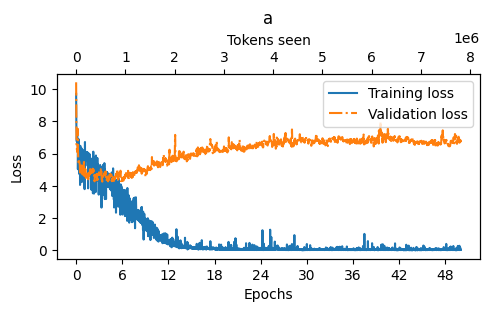

In [46]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator


def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses,title=None):
    fig, ax1 = plt.subplots(figsize=(5, 3))

    # Plot training and validation loss against epochs
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(epochs_seen, val_losses, linestyle="-.", label="Validation loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))  # only show integer labels on x-axis

    # Create a second x-axis for tokens seen
    ax2 = ax1.twiny()  # Create a second x-axis that shares the same y-axis
    ax2.plot(tokens_seen, train_losses, alpha=0)  # Invisible plot for aligning ticks
    ax2.set_xlabel("Tokens seen")

    fig.tight_layout()  # Adjust layout to make room
    plt.savefig("loss-plot.pdf")
    if title is not None:
        plt.title(title)
    plt.show()
    if title is not None:
        fig.savefig('/content/images/'+title+'.png')

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses,'a')

In [47]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move model to device
model = model.to(device)

# Prepare token_ids
token_ids = text_to_token_ids("one expects that", tokenizer)
token_ids = token_ids.to(device)  # Move token_ids to the correct device

# Generate text
token_ids = generate_text_simple(
    model=model,
    idx=token_ids,  # Ensure token_ids are on the correct device
    max_new_tokens=25,
    context_size=GPT_CONFIG_124M["context_length"]
)

# Convert token_ids back to text
print("Output text:\n", token_ids_to_text(token_ids, tokenizer))


Output text:
 one expects that had six in autumn,
appear as large trees sixty years later, and are spoken of in 1855
as two


### STEP 16: IMPLEMENTING TEMPERATURE SCALING AND TOP-K SAMPLING

In [48]:
def generate(model, idx, max_new_tokens, context_size, temperature=0.0, top_k=None, eos_id=None):

    # For-loop is the same as before: Get logits, and only focus on last time step
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:, -1, :]

        # New: Filter logits with top_k sampling
        if top_k is not None:
            # Keep only top_k values
            top_logits, _ = torch.topk(logits, top_k)
            min_val = top_logits[:, -1]
            logits = torch.where(logits < min_val, torch.tensor(float("-inf")).to(logits.device), logits)

        # New: Apply temperature scaling
        if temperature > 0.0:
            logits = logits / temperature

            # Apply softmax to get probabilities
            probs = torch.softmax(logits, dim=-1)  # (batch_size, context_len)

            # Sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1)  # (batch_size, 1)

        # Otherwise same as before: get idx of the vocab entry with the highest logits value
        else:
            idx_next = torch.argmax(logits, dim=-1, keepdim=True)  # (batch_size, 1)

        if idx_next == eos_id:  # Stop generating early if end-of-sequence token is encountered and eos_id is specified
            break

        # Same as before: append sampled index to the running sequence
        idx = torch.cat((idx, idx_next), dim=1)  # (batch_size, num_tokens+1)

    return idx

In [49]:
import torch

# Set random seed for reproducibility
torch.manual_seed(123)

# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move model to the device
model = model.to(device)

# Prepare token_ids
token_ids = text_to_token_ids("Every effort moves you", tokenizer)
token_ids = token_ids.to(device)  # Move token_ids to the correct device

# Generate text with specific parameters
token_ids = generate(
    model=model,
    idx=token_ids,  # Ensure token_ids are on the correct device
    max_new_tokens=15,
    context_size=GPT_CONFIG_124M["context_length"],
    top_k=25,
    temperature=1.4
)

# Convert token_ids back to text and print
print("Output text:\n", token_ids_to_text(token_ids, tokenizer))


Output text:
 Every effort moves you famous
carefully preserved from the Prudential Assurance Company, its


### STEP 17: SAVING THE MODEL PARAMETERS

In [50]:
model = GPTModel(GPT_CONFIG_124M)
torch.save(model.state_dict(), "model.pth")

In [51]:
model = GPTModel(GPT_CONFIG_124M)
model.load_state_dict(torch.load("model.pth"))
model.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features

In [52]:
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004, weight_decay=0.1)

torch.save({
    "model_state_dict": model.state_dict(),
    "optimizer_state_dict": optimizer.state_dict(),
    },
    "model_and_optimizer.pth"
)

In [53]:
checkpoint = torch.load("model_and_optimizer.pth")
model = GPTModel(GPT_CONFIG_124M)
model.load_state_dict(checkpoint["model_state_dict"])
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4, weight_decay=0.1)
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
model.train();

## Experiment 1: Varying Epochs and Learning Rate

Training completed in 18.63 minutes.


KeyboardInterrupt: 

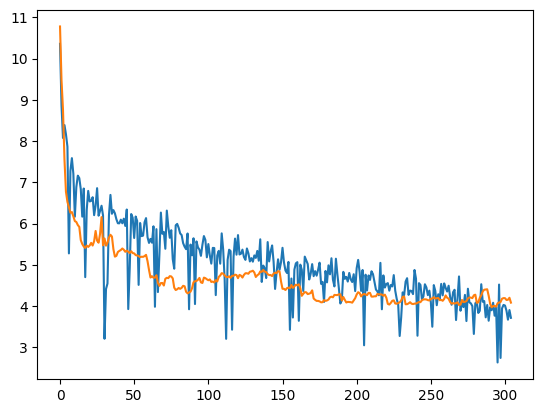

In [54]:

import matplotlib.pyplot as plt

epochs_list = [5, 10, 20, 50, 100, 200, 500]
learning_rates = [1e-4, 1e-3, 1e-2]
results_exp1 = {}

for lr in learning_rates:
    for epochs in epochs_list:
        # model = build_model()  # Replace with your model-building function
        # optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        # train_losses, val_losses = train_model(model, optimizer, train_loader, val_loader, epochs=epochs)  # Replace with your training function
        model = GPTModel(GPT_CONFIG_124M)
        model.to(device)
        optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=0.1) #A

        num_epochs = epochs
        train_losses, val_losses, tokens_seen = train_model_simple(
            model, train_loader, val_loader, optimizer, device,
            num_epochs=num_epochs, eval_freq=num_epochs/2, eval_iter=1,
            start_context="He said we came here", tokenizer=tokenizer
        )

        end_time = time.time()
        execution_time_minutes = (end_time - start_time) / 60
        print(f"Training completed in {execution_time_minutes:.2f} minutes.")

        key = f"LR={lr}_Epochs={epochs}"
        results_exp1[key] = (train_losses, val_losses, tokens_seen)

        plt.plot(train_losses, label=f"{key} Train")
        plt.plot(val_losses, label=f"{key} Val")
plt.title("Experiment 1: Epochs and Learning Rate")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()
plt.savefig("/content/images/Exper1.png")

for key, (train_losses, val_losses, tokens_seen) in results_exp1.items():
  epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
  plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses, f"{key}")

## Experiment 2: Varying Transformer Layers

In [ ]:

layer_counts = [1, 3, 5, 7, 12]
results_exp2 = {}

for n_layers in layer_counts:
    GPT_CONFIG_124M_test = {
      "vocab_size": 50257,    # Vocabulary size
      "context_length": 256, # Context length
      "emb_dim": 768,         # Embedding dimension
      "n_heads": 12,          # Number of attention heads
      "n_layers": n_layers,         # Number of layers
      "drop_rate": 0.1,       # Dropout rate
      "qkv_bias": False       # Query-Key-Value bias
    }
    model = GPTModel(GPT_CONFIG_124M_test)
    model.to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004, weight_decay=0.1)

    num_epochs = 50
    train_losses, val_losses, tokens_seen = train_model_simple(
        model, train_loader, val_loader, optimizer, device,
        num_epochs=num_epochs, eval_freq=num_epochs/2, eval_iter=1,
        start_context="He said we came here", tokenizer=tokenizer
    )

    end_time = time.time()
    execution_time_minutes = (end_time - start_time) / 60
    print(f"Training completed in {execution_time_minutes:.2f} minutes.")

    results_exp2[n_layers] = (train_losses, val_losses, tokens_seen)
    plt.plot(train_losses, label=f"{n_layers} Layers Train")
    plt.plot(val_losses, label=f"{n_layers} Layers Val")

plt.title("Experiment 2: Transformer Layers")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()
plt.savefig("/content/images/Exper2.png")

for n_layers, (train_losses, val_losses, tokens_seen) in results_exp2.items():
  epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
  plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses, f"{n_layers} Layers")

## Experiment 3: Varying Attention Heads

In [ ]:

attention_heads = [1, 2, 4, 8]
results_exp3 = {}

for heads in attention_heads:
    GPT_CONFIG_124M_test = {
      "vocab_size": 50257,    # Vocabulary size
      "context_length": 256, # Context length
      "emb_dim": 768,         # Embedding dimension
      "n_heads": heads,          # Number of attention heads
      "n_layers": 12,         # Number of layers
      "drop_rate": 0.1,       # Dropout rate
      "qkv_bias": False       # Query-Key-Value bias
    }
    model = GPTModel(GPT_CONFIG_124M_test)
    model.to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004, weight_decay=0.1)

    num_epochs = 50
    train_losses, val_losses, tokens_seen = train_model_simple(
        model, train_loader, val_loader, optimizer, device,
        num_epochs=num_epochs, eval_freq=num_epochs/2, eval_iter=1,
        start_context="He said we came here", tokenizer=tokenizer
    )

    end_time = time.time()
    execution_time_minutes = (end_time - start_time) / 60
    print(f"Training completed in {execution_time_minutes:.2f} minutes.")

    results_exp3[heads] = (train_losses, val_losses, tokens_seen)
    plt.plot(train_losses, label=f"{heads} Heads Train")
    plt.plot(val_losses, label=f"{heads} Heads Val")

plt.title("Experiment 3: Attention Heads")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()
plt.savefig("/content/images/Exper3.png")

for heads, (train_losses, val_losses, tokens_seen) in results_exp3.items():
  epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
  plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses, f"{heads} Heads")

Training completed in 80.17 minutes.


## Experiment 4: Ablation Studies

Training completed in 36.28 minutes.
Training completed in 50.92 minutes.
Training completed in 65.56 minutes.


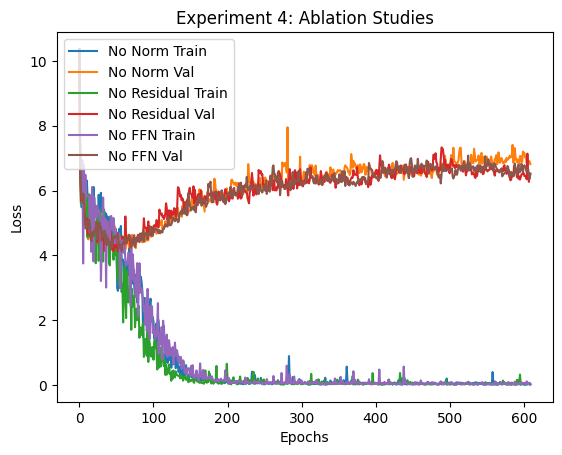

<Figure size 640x480 with 0 Axes>

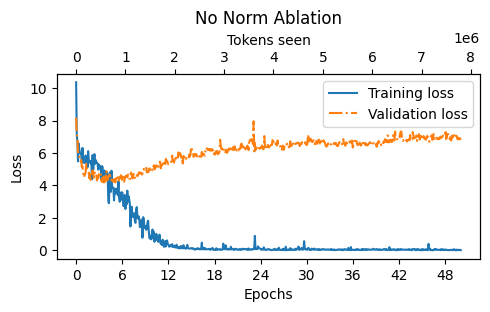

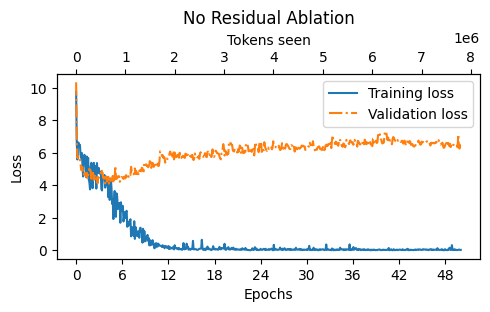

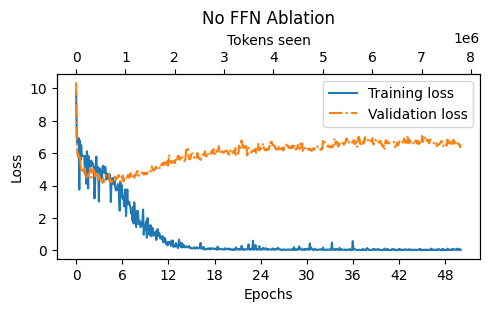

In [55]:

ablation_configs = {
    "No Norm": {"norm": False, "residual": True, "ffn": True},
    "No Residual": {"norm": True, "residual": False, "ffn": True},
    "No FFN": {"norm": True, "residual": True, "ffn": False},
}

results_exp4 = {}

for name, config in ablation_configs.items():
    GPT_CONFIG_124M_test = GPT_CONFIG_124M.copy()
    GPT_CONFIG_124M_test.update(config)
    model = GPTModel(GPT_CONFIG_124M_test)
    model.to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004, weight_decay=0.1)

    num_epochs = 50
    train_losses, val_losses, tokens_seen = train_model_simple(
        model, train_loader, val_loader, optimizer, device,
        num_epochs=num_epochs, eval_freq=num_epochs/2, eval_iter=1,
        start_context="He said we came here", tokenizer=tokenizer
    )

    end_time = time.time()
    execution_time_minutes = (end_time - start_time) / 60
    print(f"Training completed in {execution_time_minutes:.2f} minutes.")

    results_exp4[name] = (train_losses, val_losses, tokens_seen)
    plt.plot(train_losses, label=f"{name} Train")
    plt.plot(val_losses, label=f"{name} Val")

plt.title("Experiment 4: Ablation Studies")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()
plt.savefig("/content/images/Exper4.png")

for name, (train_losses, val_losses, tokens_seen) in results_exp4.items():
  epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
  plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses, f"{name} Ablation")

In [ ]:
!zip -r /content/images.zip /content/images/

In [ ]:
from google.colab import files
files.download("/content/images.zip")